# Train the Model

In this part, I am not going to show or explain all the training file. 
Instead, I will show you some important part. So, you can modify here regarding to your dataset.

Here is my configuration:

In [ ]:
class SpaceNetConfig(Config):
    '''
        Configuration for SpaceNet Dataset
    '''

    # Configuration name
    NAME = "spaceNet1"

    # I have GTX 1050 Ti, 4 GB RAM
    # It did not work with resnet101. So, I used resnet50 for backbone
    BACKBONE = 'resnet50'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    BATCH_SIZE = 25
    NUM_CLASSES = 1 + 1  # 1 (Bulding + Backround)

    # Actually, all the training data is 650x650
    # but the input size should be the multiple of 2^6
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 640
    
    # You can change regarding to yout datset
    STEPS_PER_EPOCH = 140
    DETECTION_MAX_INSTANCES = 90
    LEARNING_RATE = 0.001
    
    VALIDATION_STEPS = 10
    
    
config = SpaceNetConfig()
config.display()

# Data

Here is 'Data' part. You should override these methods 
(also check matterport's implementation):

In [ ]:
class SpaceNetDataset(utils.Dataset):

    def load_image(self, image_id):
        '''
        Args: 
                image_id: The number in the image name
        Return:
                The numpy version of the given image (H,W,3)
        ''' 
        #resimYolu holds the path of desired image.
        resimYolu = 'D:/DATASET/SpaceNet/Train/RGB-SpaceNet/'+str(image_id)+'train.png'
        imggg = PIL.Image.open(resimYolu)
        imgarr = np.array(imggg) 
        imggg.close()
        return imgarr

    def load_mask(self, image_id):
        '''
        Args: 
                image_id: The number in the image name
        Return:
                masks: The bool array like the sahpe of (height, width, number of instances).
                        It should be created for each mask.
                class_ids: 1-d array for each mask. The sahpe is like : (1, number of instances times '1')
        '''
        ResimPATH = 'D:/DATASET/SpaceNet/Train/Mask-SpaceNet/'
        ResimAdi = ResimPATH + str(image_id)+'amask.png' # Holds the mask path
        ResimData = 'D:/DATASET/SpaceNet/Train/GeoJSON-SpaceNet/'+str(image_id)+'ageo.geojson' # Holds the geojson path

        # Open the given image and conveert it to the numpy array.
        imggg = PIL.Image.open(ResimAdi).convert("L") # Convert to greyscale image.
        imgarr = np.array(imggg) 
        imggg.close()

        # Create boolean array
        boolArray = imgarr>=70 # 70 is my treshold to distinguish the buildings.

        # Open the GeoJSON file.
        with open(ResimData) as f:
            data = json.load(f)
            
        instance_masks = [] # How many instances are there in the given image.
        class_ids = []
        
        for i in range(len(data['features'])):
            if str(data['features'][i]['geometry']['type']) != 'Point':
                instance_masks.append(boolArray)
                class_ids.append(1)             
        maskA = np.dstack(instance_masks) # Mask is ready.
        
        class_ids = np.array(class_ids, dtype=np.int32)
        return maskA, class_ids
          
    def image_reference(self, image_path):
        """
            If you get an error from an image, reach its information easily.
        """   
        import geoio # To open TIF files.
        
        if image_path[-4:] == '.tif':
            return geoio.GeoImage(image_path)
        else:
            raise ValueError('Give the TIF File!')
            
    def load_data(self, images_dir):
        '''
            Load all the images from the given path.
        '''
        ResimAdlari = os.listdir(images_dir)   
        # Add class
        self.add_class("yapi", 1, "yapi")     
        for i in range(len(ResimAdlari)):               
            self.add_image("yapi", image_id=int(ResimAdlari[i][0:-10]), path=None, width=650, height=650)   

# Train

Then, we are ready to train our model.

In [ ]:
# Training - 1
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=150, 
            layers='heads')

# Training - 2
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=200,
            layers='heads')

# Training - 3
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=400,
            layers='3+')

# Training - 4
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE/10,
            epochs=600,
            layers='3+')

# Training - 5
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/100, 
            epochs=800, 
            layers='heads')

Note that, If you have better GPU or enough time, you can increase the training time.

# Test Results

Please notice that there are different types of buildings..

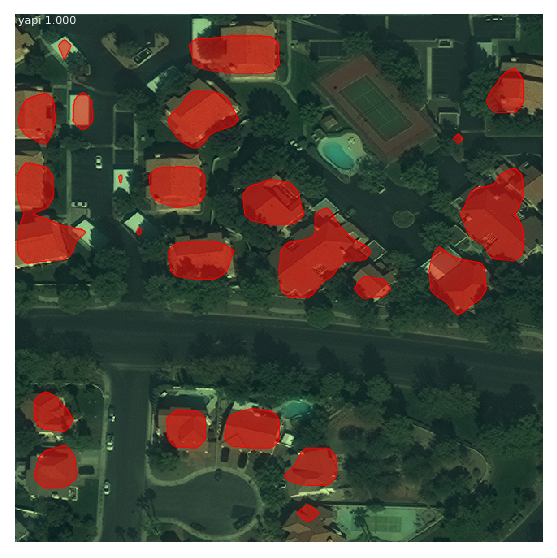

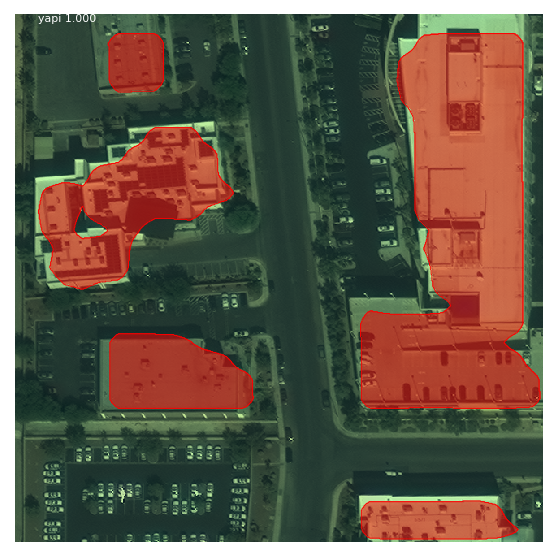

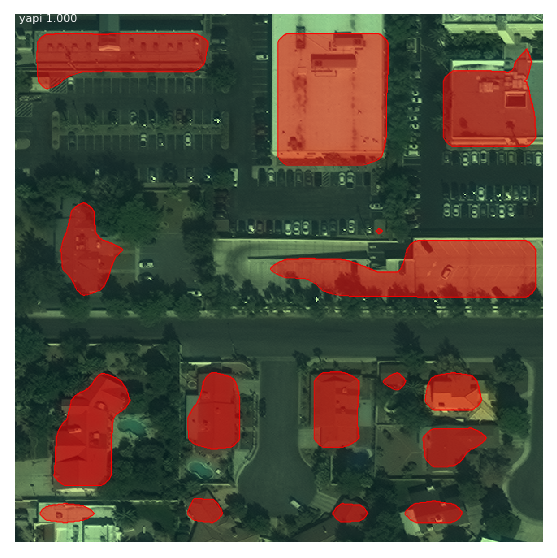

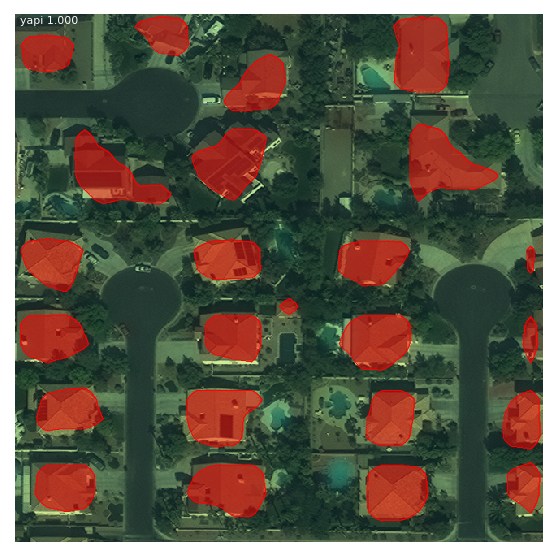

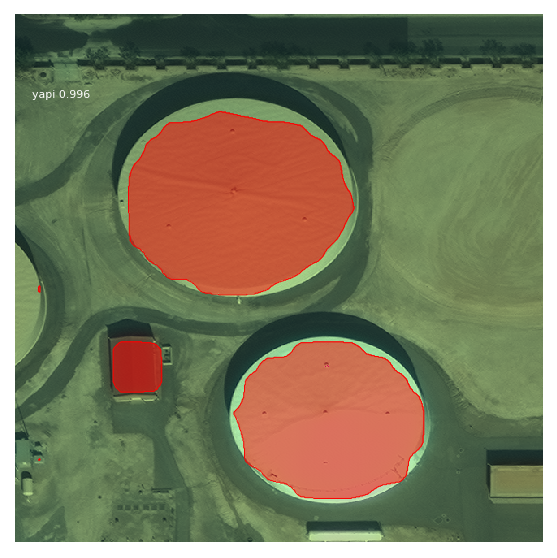

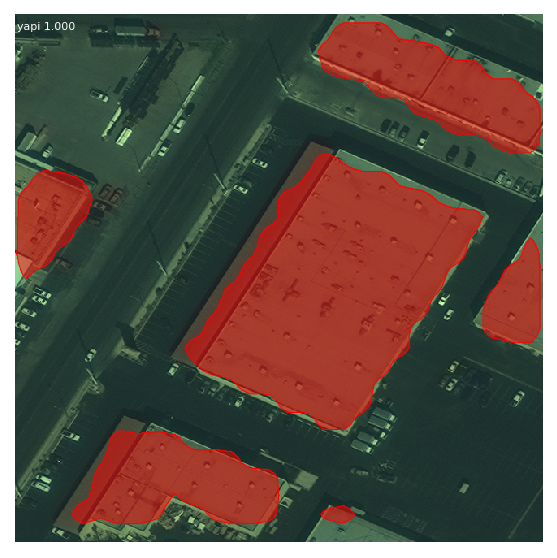

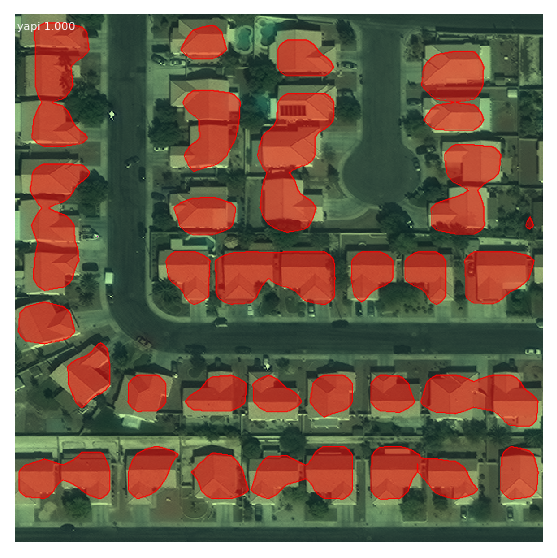

It can also guess wrong

Although it says that there was no building, they were located left side of the image.

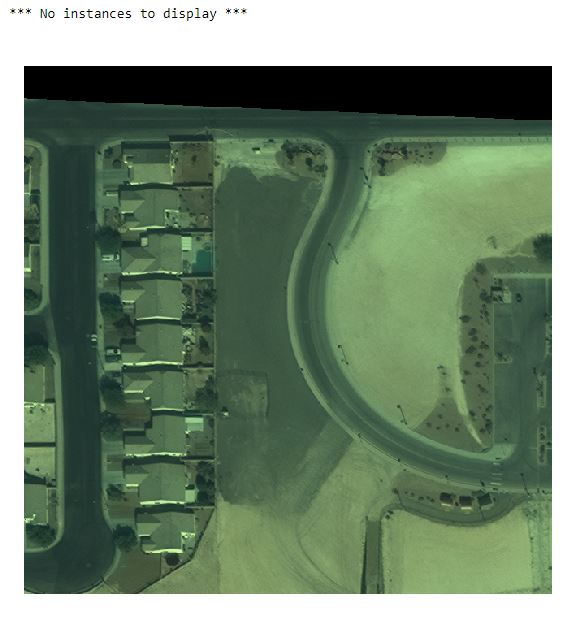

Park area is not a building..

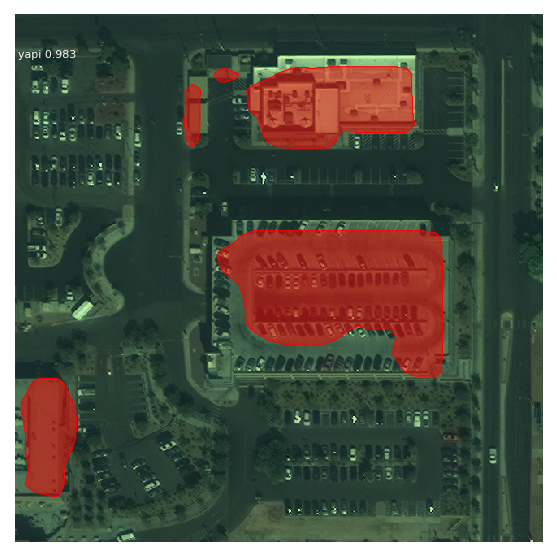